# Uniform Sampling Tests on Polygones

This repository deals with sampling methods from $(K-1)$ dimensional polytopes. 


1. imports:


In [3]:
import sys
sys.path.append('../')

import numpy as np
from numpy.random import dirichlet
from scipy.spatial import ConvexHull
import ternary
import matplotlib.pyplot as plt
import matplotlib
import torch

from composition_stats import ilr, ilr_inv

from mhar import walk

from ensemblecalibration.calibration.projections import project_point2D, plane_to_coordinate3D, project_points2D, planes_to_coordinates3D

plt.rcParams['figure.dpi'] = 150
# plt.rcParams['figure.figsize'] = (4, 4)

### Initialize setting

### sample points from dirichlet distribution

sampling points form the Dirichlet distribution yields uniform samples over the (M-1) simplex. 

In particular, for M=3, and $\alpha_j=1$ for $j=1,2,3$, the density is given by

$f(x_1,x_2, x_3) = \frac{1}{B(1)} $ with $\sum_{i=1}^3 x_i=1$, $x_i \in [0, 1]$ for $i \in {1,2,3}$ and

$$ B(\alpha) = \frac{\prod_{i=1}^K \Gamma(\alpha_i)}{\gamma(\sum_{i=1}^K\alpha_i)}$$

 the multivariate beta function.

In [5]:
points = dirichlet([1]*3, size=10000) # alpha_i = 1 for i=1,2,3

points[points[:, 1] <= 0.5].shape

(7524, 3)

 ## plot  3-simplex with  uniformly drawn points

/Users/mirajuergens/opt/miniconda3/envs/uncertaintyestimation/lib/python3.10/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


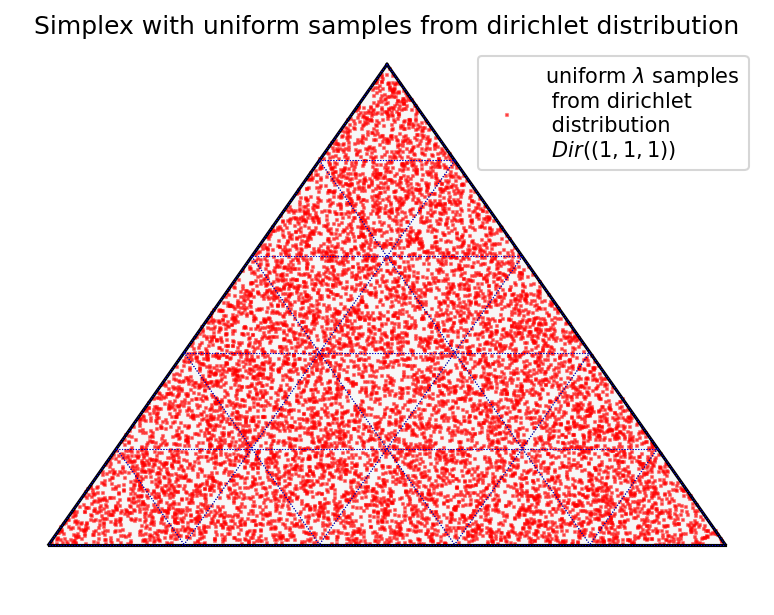

In [6]:
matplotlib.rcParams.update({'font.size': 10})

scale = 1

# ternary figure
fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Set ticks

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially
tax.scatter([tuple(points[i]) for i in range(len(points))], marker='s', color='red', s= 1, alpha=0.5, label='uniform $\lambda$ samples \n from dirichlet \n distribution \n $Dir((1,1,1))$')
# tax.scatter(predicts, marker='D', color='b')

tax.legend()

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

# title
tax.set_title('Simplex with uniform samples from dirichlet distribution')

plt.show()



### Polytope of 3 predictors in the 2-simplex

In [7]:
predicts = [(0,0,1), (0, 1/2, 1/2), (1,0,0)] # point predictions of three predictive models
# as array
predicts_array = np.stack([np.asarray(predicts[i]) for i in range(len(predicts))])

### Computation of the convex hull using Scipy

first step: project the points on the 2D plane (otherwise scipy throws an error)

In [ ]:
predicts_2D = project_points2D(predicts)

now compute teh convex hull

In [13]:
# compute convex hull
hull = ConvexHull(predicts_2D)


### Sampling convex combinations of predictions: by uniform sampling from the simplex

In [8]:
# function for uniformly sampling weights from the dirichlet distribution
def sample_predictions_uniform_simplex(preds: np.ndarray, size: int = 1000):
    """function for sampling new convex combinations of the predictions using coefficients uniformly sampled
        from the (dim -1) simplex.

    Parameters
    ----------
    preds : np.ndarray of shape (n_predictions, 3) (must be three dimensional for visualizing)
        array of point predictions 
    size : int, optional
        number of samples, by default 1000

    Returns
    -------
    np.ndarray
        array of samples convex combinations
    """

    dim = len(preds) # defines shape of weights
    lambdas = dirichlet([1]*dim, size=size) # vectors of samples convex combinations of shape (size, dim)
    preds_new = lambdas @ preds 

    return preds_new


In [9]:

preds_samples = sample_predictions_uniform_simplex(predicts_array, size=10000)

### function for getting the pairs of vertices connecting the convex hull of a number of 3-dimensional points sampled from the 2-simplex:

Using a projection to the 2-dimensional plane and the respective backtransformation

In [10]:
def get_vertex_pairs_hull(points3D: np.ndarray):
    """returns an array of vertices for the given 3-dimensional points in the 2-simplex.
    Works by first projecting them int the 2-dimensional coordinate plane, calculating the vertices of the convex hull,
     and then back-transformin to 3-dimensions.

    Parameters
    ----------
    points3D : np.ndarray of shape (n_points, 3)
        initial points

    Returns
    -------
    np.ndarray of shape (n_vertices, 3)
        vertex points
    """

    proj_points = project_points2D(points3D=points3D) # projected on two-dimensional plane to compute ConvexHull
    hull = ConvexHull(proj_points)
    vertices2d = proj_points[hull.vertices]

    vertices = planes_to_coordinates3D(vertices2d) # back projection 

    return vertices


get_vertex_pairs_hull(predicts)

array([[0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0.5, 0.5]])

In [23]:
test_vec = np.array([[.2, .2, .6], [.4, .4, .2]])
out = ilr(predicts_array)
out

/Users/mirajuergens/opt/miniconda3/envs/uncertaintyestimation/lib/python3.10/site-packages/composition_stats/__init__.py:467: RuntimeWarning: divide by zero encountered in log
  lmat = np.log(mat)
/Users/mirajuergens/opt/miniconda3/envs/uncertaintyestimation/lib/python3.10/site-packages/composition_stats/__init__.py:469: RuntimeWarning: invalid value encountered in subtract
  return (lmat - gm).squeeze()


array([[nan, nan],
       [nan, nan],
       [nan, nan]])

In [ ]:
def get_vertex_pairs_hull_iso(points: np.ndarray):
    """returns an array of vertices for the given 3-dimensional points in the 2-simplex.
    Works by first projecting them int the 2-dimensional coordinate plane, calculating the vertices of the convex hull,
     and then back-transformin to 3-dimensions.

    Parameters
    ----------
    points3D : np.ndarray of shape (n_points, dim)
        initial points

    Returns
    -------
    np.ndarray of shape (n_vertices, 3)
        vertex points
    """

    proj_points = project_points2D(points3D=points3D) # projected on two-dimensional plane to compute ConvexHull
    hull = ConvexHull(proj_points)
    vertices2d = proj_points[hull.vertices]

    vertices = planes_to_coordinates3D(vertices2d) # back projection 

    return vertices

### plot samples in the convex hull of predictions

Text(0.5, 1.0, 'Convex Hull of predictors')

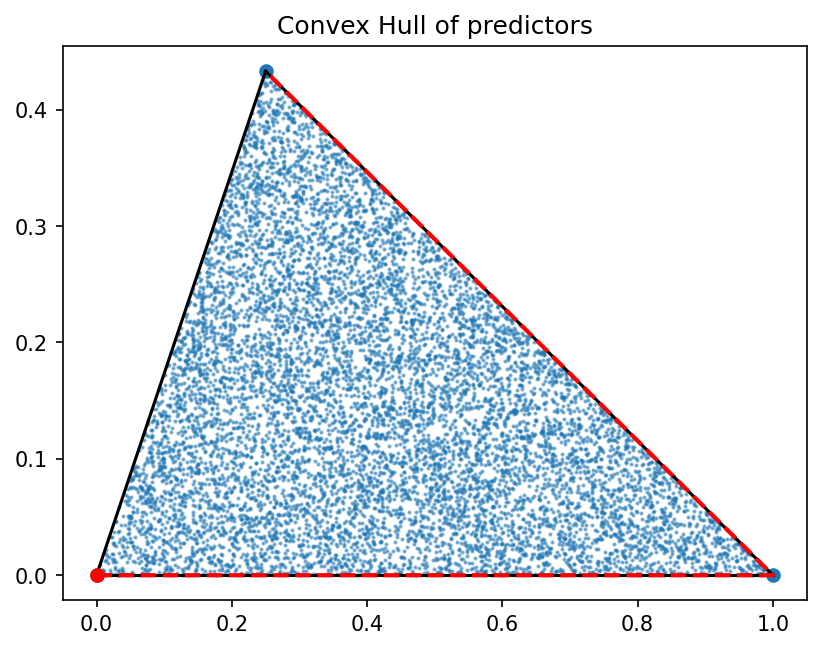

In [12]:
plt.plot(predicts_2D[:,0], predicts_2D[:, 1], 'o')
for simplex in hull.simplices:
    plt.plot(predicts_2D[simplex, 0], predicts_2D[simplex, 1], 'k-')
plt.plot(predicts_2D[hull.vertices, 0], predicts_2D[hull.vertices, 1], 'r--', lw=2)
plt.plot(predicts_2D[hull.vertices[0], 0], predicts_2D[hull.vertices[0], 1], 'ro')


proj_samples = project_points2D(preds_samples)
plt.scatter(proj_samples[:,0], proj_samples[:,1], alpha=0.5, s=1)

plt.title("Convex Hull of predictors")

polytope within the 2-simplex:

/Users/mjuergens/miniconda3/envs/uncertaintyestimation/lib/python3.10/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


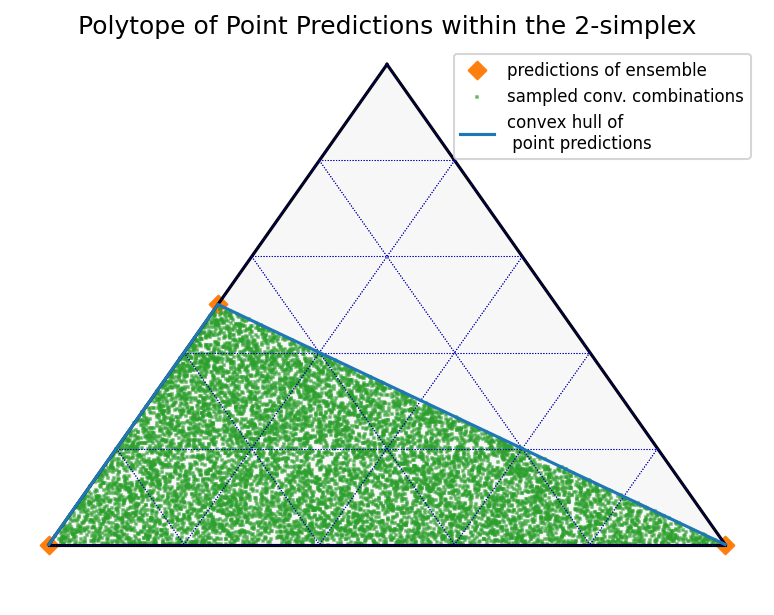

In [21]:
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.scatter(predicts, marker='D', label='predictions of ensemble')
tax.scatter(preds_samples, marker='s', s=1.5, alpha=0.5, label='sampled conv. combinations')
tax.plot(predicts, label='convex hull of \n point predictions')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('Polytope of Point Predictions within the 2-simplex')
plt.legend(fontsize=8)


### Test 2: $M=6$ predictors

#### 1. sampling of predictions by unifomrly sampling from the space of all convex combinations

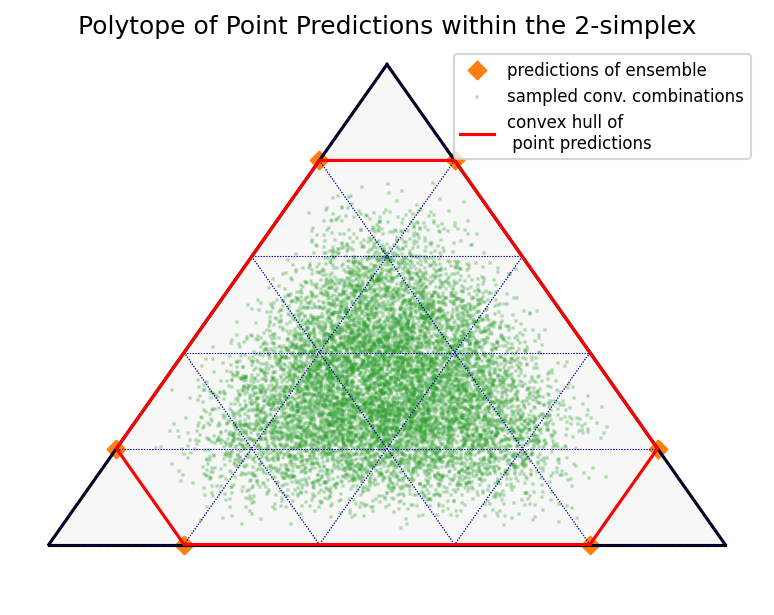

In [15]:
predicts = [(0.2, 0.8, 0.0), (0.8, .2, 0.0), (0.0, .8, .2), (0.0, .2, .8), (.8, 0, .2), (.2, 0, .8)]

# as array
preds_array = np.stack([np.asarray(predicts[i]) for i in range(len(predicts))])
# vertices of convex hull
preds_vertices = get_vertex_pairs_hull(preds_array)

preds_samples = sample_predictions_uniform_simplex(preds_array, size=10000)

# PLOT 
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.scatter(predicts, marker='D', label='predictions of ensemble')
tax.scatter(preds_samples, marker='s', s=1.5, alpha=0.2, label='sampled conv. combinations')
tax.plot(preds_vertices, color = 'r', label='convex hull of \n point predictions')
tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='r')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('Polytope of Point Predictions within the 2-simplex')
plt.legend(fontsize=8)

#### 2. sampling by using an MCMC algorithm (matrix hit and run)

function which yields the inequality constraints from the polytope:

In [60]:
def get_polytope_equations(points3D: np.ndarray):
    """function exrtacting the hyperplane inequality constraints 
    given points in the 3-dim space from a 2-simplex

    Parameters
    ----------
    points3D : np.ndarray of shape (n_points, 3)
        points from a 2-simplex

    Returns
    -------
    tensors A of shape (n_facets, 2)
            b of shape (n_facets, 1)

        defining the polytope P in a way s.t. 

            P = {x in R^2: Ax <= b}
    """

    proj_points = project_points2D(points3D=points3D) # project to 2 dimensions
    hull = ConvexHull(proj_points) # compute convex hull

    eqs = hull.equations # hyperplane equations of the facets of shape (n_facets, 3)

    A = eqs[:, :-1]
    b = - eqs[:, -1:]

    return A, b


In [68]:
A, b = get_polytope_equations(preds_array)

# need an inner point to start the random walk
x_0 = torch.from_numpy(project_point2D(np.array([1/3, 1/3, 1/3,]))).view(2, -1).type(torch.FloatTensor)
A = torch.from_numpy(A).type(torch.FloatTensor)
b = torch.from_numpy(b).type(torch.FloatTensor)

X = walk(z=10000,
ai=A,
bi=b,
ae = torch.empty(0),
be = torch.empty(0),
x_0=x_0,
T=1, 
device='cpu',
warm=0,
seed=None,
thinning=None
)

print(X)
print(X.shape)

n:  2   mi: 6   me: 0   z: 10000
Automatic Thinning factor:  8
tensor([[0.1392, 0.2208],
        [0.5662, 0.1298],
        [0.6653, 0.4377],
        ...,
        [0.3359, 0.1462],
        [0.4486, 0.6357],
        [0.5792, 0.6084]])
torch.Size([10000, 2])


### now project them back to 3 dimension


In [69]:
x_projected = planes_to_coordinates3D(X.numpy())
x_projected

array([[0.01168594, 0.25497644, 0.73333762],
       [0.49123229, 0.1499059 , 0.35886182],
       [0.41264531, 0.5053733 , 0.08198139],
       ...,
       [0.25145657, 0.16878866, 0.57975478],
       [0.08156553, 0.73398971, 0.18444476],
       [0.227959  , 0.70251663, 0.06952437]])

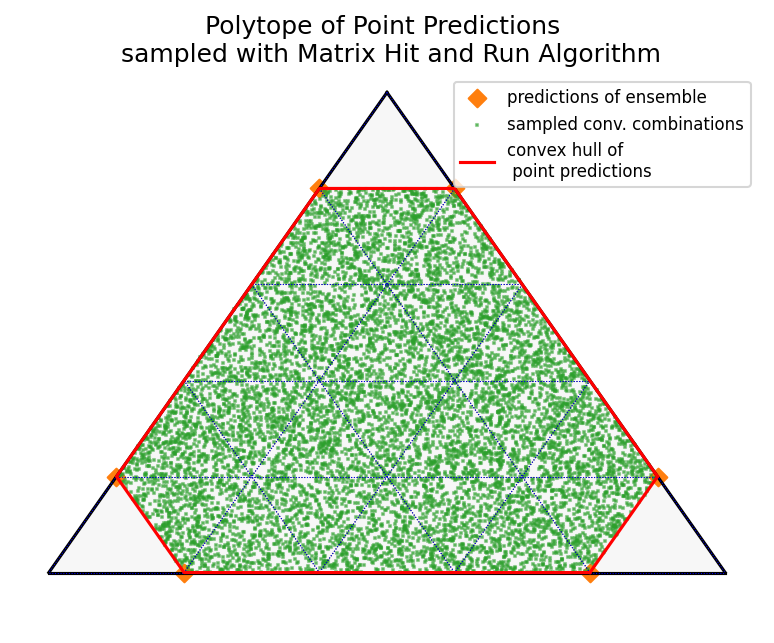

In [71]:
# PLOT 
scale = 1

fig, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# scatter predictors
tax.scatter(predicts, marker='D', label='predictions of ensemble')
tax.scatter(x_projected, marker='s', s=1.5, alpha=0.5, label='sampled conv. combinations')
tax.plot(preds_vertices, color = 'r', label='convex hull of \n point predictions')
tax.plot(preds_vertices[[0, len(preds_vertices) -1]], color='r')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.title('Polytope of Point Predictions \n sampled with Matrix Hit and Run Algorithm')
plt.legend(fontsize=8)

### Test 3: predictions point within the polytope

In [72]:
predicts.append((1/3, 1/3, 1/3))
preds_array = np.stack([np.asarray(predicts[i]) for i in range(len(predicts))])